Generating a dataset ...
Training ...


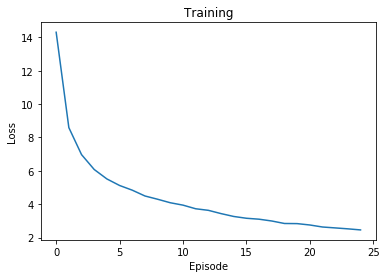

[14 17 26 59 71 84 86 93 96 96]
[49 23 28 31 24 16 44 35 98 27] [16 23 24 27 28 31 35 44 49 98] [16 23 24 27 28 31 35 44 49 98]
[87  8 99 69 37 80 40  7 56 59] [ 7  8 37 40 56 59 69 80 87 99] [ 7  8 37 40 56 59 69 80 87 99]
[89 44 22 49 99 53 46 17 58 65] [17 22 44 46 49 53 58 65 89 99] [17 22 44 46 49 53 58 65 89 99]
[17 86 58 56 65 87 93  9 99 82] [ 9 17 56 58 65 82 86 87 93 99] [ 9 17 56 58 65 82 87 93 93 99]
[ 1 15 88 59 14 45 79 82 89 60] [ 1 14 15 45 59 60 79 82 88 89] [ 1 14 15 45 59 60 79 82 88 89]
[86 14 61 72 14 42 54  8  2  3] [ 2  3  8 14 14 42 54 61 72 86] [ 2  3  8 14 14 42 54 61 72 86]
[86 11 32 35 33 74 10 14 90  1] [ 1 10 11 14 32 33 35 74 86 90] [ 1 10 14 14 32 33 35 74 86 90]
[ 1 35 60 17 41 71 71 59 58 26] [ 1 17 26 35 41 58 59 60 71 71] [ 1 17 26 35 41 58 58 60 71 71]
[60 68 41 67 21  4 64 45  9 11] [ 4  9 11 21 41 45 60 64 67 68] [ 4  9 11 21 41 45 60 64 67 68]
[55 62 61 34 95 11 40 70 37 50] [11 34 37 40 50 55 61 62 70 95] [11 34 37 40 50 55 61 62 70 95]
[79  2 1

In [23]:
""" 
Pointer networks example
"""
__author__ = "AL-Tam Faroq"
__copyright__ = "Copyright 2020, UALG"
__credits__ = ["Faroq AL-Tam"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Faroq AL-Tam"
__email__ = "ftam@ualg.pt"
__status__ = "Production"

import sys
sys.path.append("..")

# local files
from seq2seq_with_deep_attention.datasets.SortingDataset import SortingDataset
from seq2seq_with_deep_attention.models.PointerNetwork import PointerNetwork

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler # to do train-validate spilit

# plot
import matplotlib.pyplot as plt

# utilis
import random
import math



random_seed = torch.manual_seed(45)

# constants
IN_FEATURES = 1 # depends on the demnationality of the input
HIDDEN_SIZE = 256
BATCH_SIZE = 64
RANGE = [0, 100]
SOS_SYMBOL = -1 # start of sequence symbol 
DATASET_SIZE = 50000
EPOCHS = 25


VALIDATION_RATIO = .2



def main():

    ds = SortingDataset(range_=RANGE, SOS_SYMBOL=SOS_SYMBOL, num_instances=DATASET_SIZE)
    # train-validate spilit
    ds_len = len(ds)
    indexes = list(range(ds_len))
    random.shuffle(indexes) # shuffle them
    spilit_spot = int(math.floor(VALIDATION_RATIO * ds_len))
    
    train_indexes = indexes[spilit_spot:]
    validation_indexes = indexes[:spilit_spot]

    # samples 
    train_sampler = SubsetRandomSampler(train_indexes)
    validation_sampler = SubsetRandomSampler(validation_indexes)

    # loaders
    train_dataloader = DataLoader(ds,
                            sampler=train_sampler,
                            batch_size=BATCH_SIZE,
                            num_workers=0)

    validation_dataloader = DataLoader(ds,
                            sampler=validation_sampler,
                            batch_size=BATCH_SIZE,
                            num_workers=0)
    


    # The Pointer Network model
    pointer_network = PointerNetwork(in_features=IN_FEATURES,
                                 hidden_size=HIDDEN_SIZE,
                                 batch_size=BATCH_SIZE,
                                 device='gpu')

    
    # loss function and optimizer
    loss_function = nn.NLLLoss()
    opitmizer = optim.Adam(pointer_network.parameters(), lr=0.00005)

    ################## Training #############
    print('Training ...')
    pointer_network.train()
    epochs_loss = []
    for _ in range(EPOCHS):
        losses = []
        for batch, target_seq in train_dataloader:
            _, sequence_length = batch.shape
            # put them in the same device as the model's
            target_seq = target_seq.to(pointer_network.device)

            # zero grad        
            pointer_network.zero_grad()
            pointer_network.encoder.zero_grad()
            pointer_network.decoder_cell.zero_grad()
            batch = batch.unsqueeze(2).float() # add another dim for features 
            
            # apply model
            attentions, pointers = pointer_network(batch)

            # loss calculation
            loss = 0
            # can be replaced by a single elegant line, but I do it like this for better readability
            for i in range(sequence_length):
                loss += loss_function(attentions[:, i, :].to(pointer_network.device), target_seq[:, i])
            #back propagate
            loss.backward()
            opitmizer.step()
            # loss curve
            losses.append(loss.detach().cpu().item())
            # uncomment this line to check how store all training tuples
            #samples.append((target_seq.detach().cpu().numpy(), pointers.detach().cpu().numpy()))  
        epochs_loss.append(sum(losses) / len(losses))

    # plot loss
    plt.figure()
    plt.title("Training")
    plt.plot(epochs_loss)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.show(block=False)

    ################## Training #############
    print('\nValidation ...')
    print('\ninput\ttarget\tpointer')
    pointer_network.eval()
    for batch, target_sequences in validation_dataloader:
        if batch.shape[0] < BATCH_SIZE:
            break # ingonre last small batch, can be padded although
        batch = batch.unsqueeze(2).float() # add another dim for features 
        attentions, pointers = pointer_network(batch)

        pointers = pointers.detach().cpu().numpy().astype(int)
        input_sequences = batch.squeeze(2).detach().cpu().numpy().astype(int)
        for input_seq, target_seq, pointer in zip(input_sequences, target_sequences, pointers):
            print(input_seq, input_seq[target_seq], input_seq[pointer])

if __name__ is '__main__':
    main()
